Import Library

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.3 MB/s eta 0:00:00


In [ ]:
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Define the dataset paths and parameters

In [ ]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
base_dir = '/content/drive/MyDrive/Wrinkle Detection Model/merged_dataset'
train_data_dir = os.path.join(base_dir, 'train', 'dataset')
val_data_dir = os.path.join(base_dir, 'valid', 'dataset')
test_data_dir = os.path.join(base_dir, 'test', 'dataset')
annotations_train_file = os.path.join(base_dir, 'train', '_annotations.csv')
annotations_val_file = os.path.join(base_dir, 'valid', '_annotations.csv')
annotations_test_file = os.path.join(base_dir, 'test', '_annotations.csv')

Load and preprocess the data

In [ ]:
batch_size = 32

In [ ]:
annotations_train = pd.read_csv(annotations_train_file)
annotations_val = pd.read_csv(annotations_val_file)
annotations_test = pd.read_csv(annotations_test_file)

annotations_train['class'] = annotations_train['class'].astype(str)
annotations_val['class'] = annotations_val['class'].astype(str)
annotations_test['class'] = annotations_test['class'].astype(str)

# Create image data generators with augmentation for training and validation
# Define custom preprocessing function
# def preprocess_image(image):
#     # Add Gaussian noise
#     noisy_image = GaussianNoise(0.1)(image, training=True)

#     # Adjust saturation
#     saturated_image = tf.image.random_saturation(noisy_image, lower=0.5, upper=1.5)

#     # Adjust brightness
#     brightened_image = tf.image.random_brightness(saturated_image, max_delta=0.2)

#     # Adjust contrast
#     contrasted_image = tf.image.random_contrast(brightened_image, lower=0.7, upper=1.3)

#     # Rescale to [0, 1]
#     preprocessed_image = tf.clip_by_value(contrasted_image, 0.0, 1.0)

#     return preprocessed_image

# Create image data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    # preprocessing_function=preprocess_image
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load and preprocess the training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=annotations_train,
    directory=train_data_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

# Load and preprocess the validation data
val_generator = val_datagen.flow_from_dataframe(
    dataframe=annotations_val,
    directory=val_data_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 17614 validated image filenames belonging to 2 classes.
Found 543 validated image filenames belonging to 2 classes.


In [ ]:
num_classes = annotations_train['class'].nunique()

Build the model

In [ ]:
# Load the MobileNetV2 model (pretrained on ImageNet)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


Train the model

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.n // batch_size,
#     epochs=10,
#     validation_data=val_generator,
#     validation_steps=val_generator.n // batch_size,
#     callbacks=[early_stopping] 
# )

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks=[early_stopping]
)


Epoch 1/10
550/550 [==============================] - 882s 1s/step - loss: 6.3940 - accuracy: 0.7409 - val_loss: 4.9948 - val_accuracy: 0.8184
Epoch 2/10
550/550 [==============================] - 559s 1s/step - loss: 4.3352 - accuracy: 0.7843 - val_loss: 3.7103 - val_accuracy: 0.7637
Epoch 3/10
550/550 [==============================] - 559s 1s/step - loss: 3.1652 - accuracy: 0.7982 - val_loss: 2.5613 - val_accuracy: 0.8555
Epoch 4/10
550/550 [==============================] - 559s 1s/step - loss: 2.3739 - accuracy: 0.8065 - val_loss: 1.9529 - val_accuracy: 0.8223
Epoch 5/10
550/550 [==============================] - 573s 1s/step - loss: 1.7925 - accuracy: 0.8162 - val_loss: 1.4920 - val_accuracy: 0.8516
Epoch 6/10
550/550 [==============================] - 569s 1s/step - loss: 1.3683 - accuracy: 0.8223 - val_loss: 1.1372 - val_accuracy: 0.8965
Epoch 7/10
550/550 [==============================] - 560s 1s/step - loss: 1.0429 - accuracy: 0.8232 - val_loss: 0.8346 - val_accuracy: 0.8730

Evaluate the model

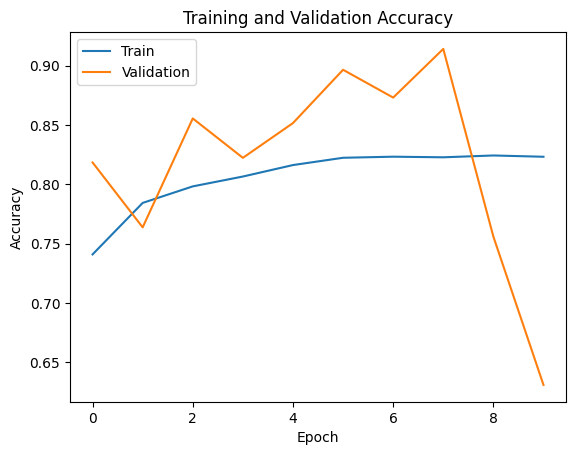

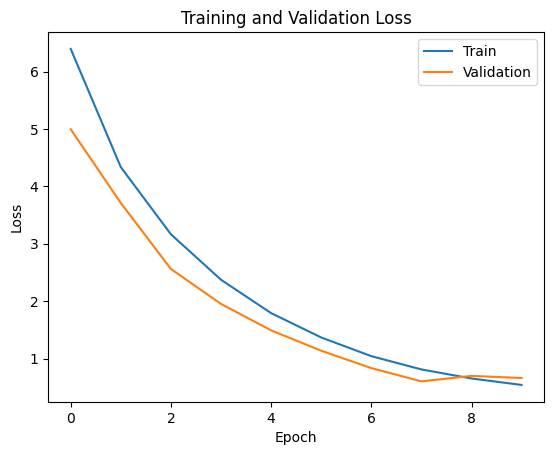

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load the annotations test file into a DataFrame
df = pd.read_csv(annotations_test_file)
df['class'] = df['class'].astype(str)

# Load and preprocess the test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory=test_data_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


Found 54 validated image filenames belonging to 2 classes.
2/2 [==============================] - 2s 1s/step - loss: 0.9790 - accuracy: 0.2407
Test loss: 0.9790
Test accuracy: 0.2407


Save Model

In [ ]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/Wrinkle Detection Model/model_mobilenetv2_V1.h5'
model.save(model_path)